In [4]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pyspark-3.3.1.tar.gz (281.4 MB)
  Preparing metadata (setup.py) ... done
  Using cached py4j-0.10.9.5-py2.py3-none-any.whl (199 kB)
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=57bc8820fd8de4d18d4d6363998a441236e41b49fb6dbf060d3b690b69d8b89a
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [5]:
from pyspark.sql import SparkSession
import os
from pyspark.sql.types import *
import seaborn as sns

In [6]:
spark = SparkSession.builder.master('local[4]').appName('ml').getOrCreate()

In [7]:
df = spark.read.csv('Social_Network_Ads.csv',header=True,inferSchema=True)

In [8]:
df

DataFrame[User ID: int, Gender: string, Age: double, EstimatedSalary: double, Purchased: int]

In [9]:
df.count()

400

In [10]:
df.show(5)

+--------+------+----+---------------+---------+
| User ID|Gender| Age|EstimatedSalary|Purchased|
+--------+------+----+---------------+---------+
|15624510|  Male|19.0|        19000.0|        0|
|15810944|  Male|35.0|        20000.0|        0|
|15668575|Female|26.0|        43000.0|        0|
|15603246|Female|27.0|        57000.0|        0|
|15804002|  Male|19.0|        76000.0|        0|
+--------+------+----+---------------+---------+
only showing top 5 rows



In [11]:
df.summary().show()

+-------+-----------------+------+------------------+----------------+------------------+
|summary|          User ID|Gender|               Age| EstimatedSalary|         Purchased|
+-------+-----------------+------+------------------+----------------+------------------+
|  count|              400|   400|               400|             400|               400|
|   mean|  1.56915397575E7|  null|            37.655|         69742.5|            0.3575|
| stddev|71658.32158119006|  null|10.482876597307927|34096.9602824248|0.4798639635968691|
|    min|         15566689|Female|              18.0|         15000.0|                 0|
|    25%|         15625395|  null|              29.0|         43000.0|                 0|
|    50%|         15694288|  null|              37.0|         70000.0|                 0|
|    75%|         15750335|  null|              46.0|         88000.0|                 1|
|    max|         15815236|  Male|              60.0|        150000.0|                 1|
+-------+-

In [12]:
pdf=df.toPandas()

In [13]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   User ID          400 non-null    int32  
 1   Gender           400 non-null    object 
 2   Age              400 non-null    float64
 3   EstimatedSalary  400 non-null    float64
 4   Purchased        400 non-null    int32  
dtypes: float64(2), int32(2), object(1)
memory usage: 12.6+ KB


In [14]:
df.groupby("Purchased").count().show()

+---------+-----+
|Purchased|count|
+---------+-----+
|        1|  143|
|        0|  257|
+---------+-----+



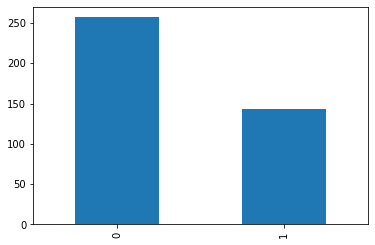

In [16]:
pdf['Purchased'].value_counts().plot.bar()

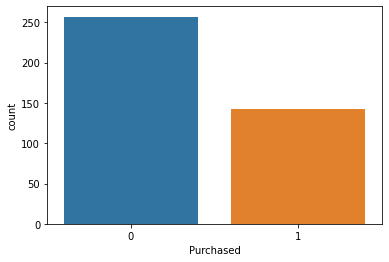

In [17]:
sns.countplot(x=pdf['Purchased'])

In [18]:
round(pdf['Purchased'].value_counts()[0]/len(pdf),2)*100

64.0

In [19]:
round(pdf['Purchased'].value_counts()[1]/len(pdf),2)*100

36.0

In [20]:
pdf.isnull().sum()

User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

In [21]:
from pyspark.sql.functions import isnull,when,count,col

In [22]:
df.select([count(when(isnull(c),c)).alias(c) for c in df.columns]).show()

+-------+------+---+---------------+---------+
|User ID|Gender|Age|EstimatedSalary|Purchased|
+-------+------+---+---------------+---------+
|      0|     0|  0|              0|        0|
+-------+------+---+---------------+---------+



In [23]:
features =['Age','EstimatedSalary']

In [24]:
pdf[features]

,Age,EstimatedSalary
0,19.0,19000.0
1,35.0,20000.0
2,26.0,43000.0
3,27.0,57000.0
4,19.0,76000.0
...,...,...
395,46.0,41000.0
396,51.0,23000.0
397,50.0,20000.0
398,36.0,33000.0


In [25]:
from pyspark.ml.feature import VectorAssembler

In [27]:
assembler = VectorAssembler(inputCols=features,
                            outputCol='features')

In [28]:
data=assembler.transform(df)

In [29]:
data.show(5)

+--------+------+----+---------------+---------+--------------+
| User ID|Gender| Age|EstimatedSalary|Purchased|      features|
+--------+------+----+---------------+---------+--------------+
|15624510|  Male|19.0|        19000.0|        0|[19.0,19000.0]|
|15810944|  Male|35.0|        20000.0|        0|[35.0,20000.0]|
|15668575|Female|26.0|        43000.0|        0|[26.0,43000.0]|
|15603246|Female|27.0|        57000.0|        0|[27.0,57000.0]|
|15804002|  Male|19.0|        76000.0|        0|[19.0,76000.0]|
+--------+------+----+---------------+---------+--------------+
only showing top 5 rows



In [30]:
traning_data,test_data=data.randomSplit([0.75,0.25],seed=0)

In [31]:
traning_data.count()

301

In [32]:
test_data.count()

99

In [33]:
195/(573+195)

0.25390625

In [35]:
traning_data.groupby("Purchased").count().select('count').show()

+-----+
|count|
+-----+
|  109|
|  192|
+-----+



In [36]:
test_data.groupby("Purchased").count().show()

+---------+-----+
|Purchased|count|
+---------+-----+
|        1|   34|
|        0|   65|
+---------+-----+



In [39]:
from pyspark.mllib.tree import RandomForest as rf

In [53]:
rf = rf()

In [54]:
model = rf.trainClassifier(traning_data,numClasses = 2, numTrees = 5, seed=42, categoricalFeaturesInfo={})

AssertionError: ignored

In [ ]:
predictions = model.transform(test_data)

In [ ]:
predictions.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+--------------------+-------------+--------------------+----------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|            features|rawPrediction|         probability|prediction|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+--------------------+-------------+--------------------+----------+
|          0|     57|           60|            0|      0|21.7|                   0.735| 67|      0|[57.0,60.0,21.7,6...|  [65.0,16.0]|[0.80246913580246...|       0.0|
|          0|     99|            0|            0|      0|25.0|                   0.253| 22|      0|[99.0,0.0,25.0,22.0]|  [117.0,1.0]|[0.99152542372881...|       0.0|
|          0|    100|           70|           26|     50|30.8|                   0.597| 21|      0|[100.0,70.0,30.8,...|  [117.0,1.0]|[0.99152542372881...|       0.0

In [ ]:
pred = predictions.select('prediction').toPandas()

In [ ]:
actual = predictions.select('Outcome').toPandas()

In [ ]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

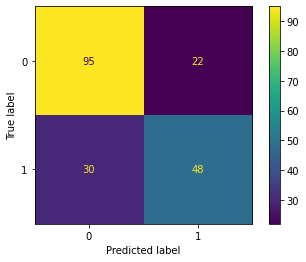

In [ ]:
ConfusionMatrixDisplay.from_predictions(actual, pred)

In [ ]:
accuracy_score(actual, pred)

0.7333333333333333

In [ ]:
print(classification_report(actual, pred))

              precision    recall  f1-score   support

           0       0.76      0.81      0.79       117
           1       0.69      0.62      0.65        78

    accuracy                           0.73       195
   macro avg       0.72      0.71      0.72       195
weighted avg       0.73      0.73      0.73       195



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
eval = MulticlassClassificationEvaluator(labelCol="Outcome", metricName= "accuracy")

In [ ]:
print("Accuracy: ",eval.evaluate(predictions))

Accuracy:  0.7333333333333333


In [ ]:
new = [89,66,25.2,34] #new person

In [ ]:
new_pred = model.transform(new)

AttributeError: ignored